In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_100d_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users

--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussMultiDimModel(dim=100, n_obs=10, marginal_of_interest=0)
📝 Created temporary observed data for prior sampling mode


In [2]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "regressor",
                          lr_scheduler_name = "constant",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)
simulator.train_summary_network(subkey_learn, regressor_config)

key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

INFO:abcnre.training.config:Using constant lr_scheduler with base learning_rate from training config
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: regressor_deepset_default_default (task: regressor)
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: regressor
INFO:abcnre.training.components.metrics:   Network: DeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.0003
INFO:abcnre.training.components.metrics:   LR scheduler: constant
INFO:abcnre.training.components.metrics:   Batch size: 256
INFO:abcnre.training.components.metrics:   Samples/epoch: 10240
INFO:abcnre.training.components.metrics:   Max epochs: 100
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.setup:Setting up regressor training
INFO:abcnre.training.components.setup:Epochs: 100, B

--- Step 1.5 : Learn Summary Stats (Optional) ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.registry:Created DeepSet network (from 'DeepSet') for regressor
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'phi_hidden_dims': [32, 16], 'rho_hidden_dims': [32, 16], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: DeepSet
INFO:abcnre.training.components.setup:Network initialized with 5,041 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 1034
INFO:abcnre.training.components.metrics:============================================================
INFO:abcnre.training.components.metrics:Starting regressor training
INFO:abcnre.training.components.metrics:Epochs: 100, Batch size: 256, Batches/epoc

✅ Updating model's summary statistics function...
📝 Created temporary observed data for prior sampling mode
✅ Summary statistics learned and updated successfully!
   - Original data dimension: (10, 100)
   - Learned summary function integrated into model
Shapes : phi_samples: (10000, 1) x_samples: (10000, 10, 100)
Shapes: summary_stats: (10000, 1) phi_samples: (10000, 1)
Correlation between summary statistics and model parameters: [[0.98278654]]


Array([[0.98278654]], dtype=float32)

In [3]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

model = simulator.model

key, key_prior = jax.random.split(key)
true_theta = model.get_prior_sample(key_prior)

true_phi = 5.
true_theta = true_theta.at[model.marginal_of_interest].set(true_phi)

key, subkey_sample = jax.random.split(key)
x_obs = model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs shape: {x_obs.shape}")

quantile_distance = .5
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
🔄 Updated sampler with new observed data.
Observation x_obs shape: (10, 100)
📊 Computed epsilon = 4.291407 for 50.0% quantile


In [4]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

--- Step 2.2: Save model to YAML (Optional) ---


INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Recherche/A

In [ ]:

print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

from abcnre.utils.comparison import are_simulators_equivalent

simulators_match = are_simulators_equivalent(simulator, simulator_loaded)
print(f"Simulators match: {'YES' if simulators_match else 'NO'} {simulators_match}")

--- Step 2.3 : Load model from YAML and check (Optional) ---


INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.regi

Using provided epsilon = 4.291407
Simulators match: ✅ True


In [ ]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="conditioned_deepset",
                          network_size = "xl",
                          training_size = "heavy",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_xl_heavy (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [7]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [8]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")


key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)  # Peu de phi storage


INFO:abcnre.inference.estimator:Using ConditionedDeepSet without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: ConditionedDeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.001
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 512
INFO:abcnre.training.components.metrics:   Samples/epoch: 51200
INFO:abcnre.training.components.metrics:   Max epochs: 500
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.metrics:   Phi storage: 10000 values
INFO:abcnre.training.components.setup:Setting up classifier training
INFO:abcnre.training.components.setup:Epochs: 500, Batch size: 512, Bat

--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for ConditionedDeepSet network
INFO:abcnre.training.registry:Created ConditionedDeepSet network (from 'ConditionedDeepSet') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.1, 'pooling_type': 'mean', 'conditioning_mode': 'concat', 'phi_hidden_dims': [128, 64, 32], 'rho_hidden_dims': [128, 64, 32], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: ConditionedDeepSet
INFO:abcnre.training.components.setup:Network initialized with 39,009 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 1040
INFO:abcnre.training.components.schedulers:Initialized reduce-on-plateau scheduler
INFO:abcnre.training.components.loop:Initialized phi storage for 10000 values
INF

✅ Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.31756892800331116
   - Total simulations: 3252369


In [9]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_classif_config.yaml


--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---


INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_summary_network_weights.npz
INFO:abcnre.simulation.io:ABCSimulator configuration sav

In [10]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)
from abcnre.utils.comparison import are_estimators_equivalent

estimators_match = are_estimators_equivalent(estimator, estimator_loaded)
print(f"Estimators match: {'YES' if estimators_match else 'NO'} {estimators_match}")

INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_classif_config.yaml


--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---


INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_100D/results/estimator/estimator_simulator_summary_network_weights.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for D

Using provided epsilon = 4.291407
Estimators match: YES True


/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


DEBUG: s_x_batch shape: (10000, 1, 1)
DEBUG: x_batch shape: (10000, 10, 100)
DEBUG: phi_values shape: (10000,)
DEBUG: s_x_batch shape: (10000, 1, 1)
DEBUG: x_batch shape: (10000, 10, 100)
DEBUG: phi_values shape: (10000,)
DEBUG: s_x_batch shape: (10000, 1, 1)
DEBUG: x_batch shape: (10000, 10, 100)
DEBUG: phi_values shape: (10000,)
DEBUG: s_x_batch shape: (10000, 1, 1)
DEBUG: x_batch shape: (10000, 10, 100)
DEBUG: phi_values shape: (10000,)


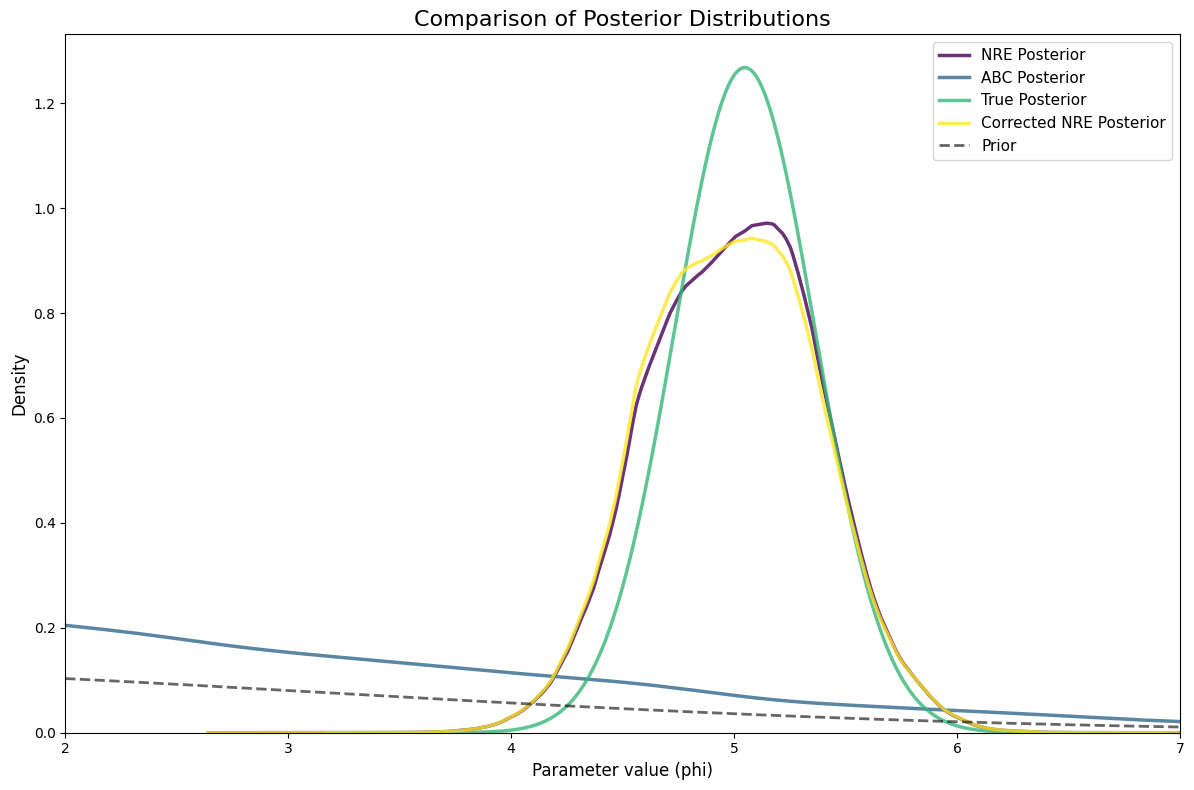

In [11]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
import numpy as np

abc_phi_samples = estimator.stored_phis
min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

n_grid = 10000  # Number of grid points for the posterior distribution
abc_phi_grid = np.linspace(min_phi, max_phi, n_grid)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(estimator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, 
                                       initial_bounds=(min_phi, max_phi), 
                                        n_grid_points=n_grid)

# Get prior for plotting
prior_pdf_values = simulator.model.prior_phi_pdf(abc_phi_grid)

true_grid, true_pdf = get_normalized_pdf(simulator.model.get_posterior_phi_distribution(simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unnormalized_corrected_nre_pdf(estimator)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
                                    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
                                    initial_bounds=(min_phi, max_phi),
                                    n_grid_points=n_grid
)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=n_grid
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(abc_phi_grid, prior_pdf_values),
    xlim=(2,7)
    # save_path=output_dir / "posterior_comparison.png"
)



In [12]:
# from abcnre.diagnostics.calibration import run_abc_sbc
# from abcnre.diagnostics.viz import plot_sbc_ranks

# # --- Step 7: Simulation-Based Calibration (SBC) ---
# print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
# import jax
# key  = jax.random.PRNGKey(42)
# num_posterior_samples = 128  
# sbc_results = run_abc_sbc(
#     key=key,
#     estimator=estimator,
#     num_sbc_rounds=10,
#     num_posterior_samples=num_posterior_samples
# )


# plot_sbc_ranks(sbc_results)

In [13]:
# print("\n--- Step 8: Creating Samplers and Running Metrics ---")
# from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf, get_sampler_from_pdf
# from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv


# # Define bounds for posterior calculation based on reference samples
# min_phi = np.min(abc_phi_samples) - 1.0
# max_phi = np.max(abc_phi_samples) + 1.0

# # --- Create all necessary sampler functions ---
# # A sampler is a function that takes (n_samples, key) and returns samples

# unorm_nre_pdf = get_unnormalized_nre_pdf(estimator)
# nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# unorm_corrected_nre_pdf = get_unnormalized_corrected_nre_pdf(
#     estimator, phi_samples=abc_phi_samples
# )
# corrected_nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_corrected_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# true_sampler = simulator.get_true_posterior_samples

# # abc_sampler = lambda: key, n_s:  simulator.get_abc_posterior_samples()

# # --- Run the metrics suite ---
# approx_samplers_dict = {
#     "NRE_Standard": nre_sampler,
#     "NRE_Corrected": corrected_nre_sampler,
#     # "ABC": 
# }

# # The key here will be split inside the function for each sampler
# key = jax.random.PRNGKey(123)
# all_metrics_results = generate_and_evaluate_metrics(
#     key=key,
#     true_sampler=true_sampler,
#     approx_samplers_dict=approx_samplers_dict,
#     n_samples=5000
# )

# print("\n--- Quantitative Results ---")
# save_metrics_to_csv(all_metrics_results, results_dir / "diagnostics_metrics.csv")